In [2]:
#helper function to show and save image
def plot(image, title="input", savefig=False):
    plt.title(title)
    plt.axis('off')
    plt.imshow(image)
    plt.show()
    
    if savefig == True:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        cv2.imwrite("output/" + title + ".png", image)

In [3]:
# input image
img1 = cv2.imread("basketball-court.ppm")
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

# output image
img2 = Image.new('RGB', (940, 500), 'white')

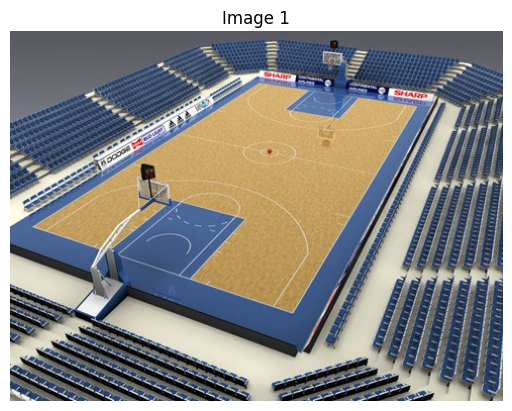

In [4]:
plot(img1, title="Image 1")

# 1.1 DLT Algorithm using pixel feature locations

In [5]:
img1_points = [[0,200], [246,45], [419,69], [287,318]]
img2_points = [[0,0], [939,0], [939,499], [0,499]]

img1_points = np.array(img1_points)
img2_points = np.array(img2_points)

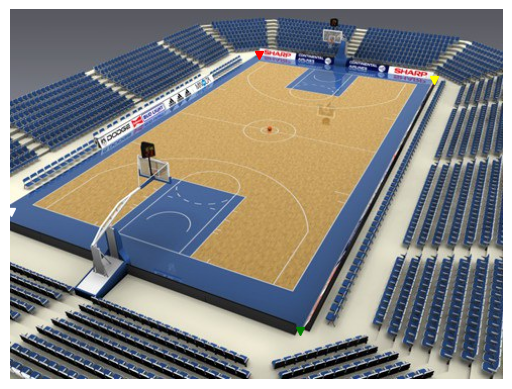

In [6]:
# plot to show the points chosen
plt.plot(0, 200, marker='v', color="white") #p1
plt.plot(246, 45, marker='v', color="red") #p2
plt.plot(419, 69, marker='v', color="yellow") #p3
plt.plot(287, 318, marker='v', color="green") #p4

plt.axis('off')
plt.imshow(img1)
plt.show()

In [7]:
# function to get the A matrix for SVD
def get_A(img1_points, img2_points):
    # initialize A as empty list
    A = []
    
    # loop through number of points - 4 points in question
    for i in range(4):
        # <variable>: input image points
        # <variable>_: output image points
        x = img1_points[i,0]
        y = img1_points[i,1]
        
        x_ = img2_points[i,0]
        y_ = img2_points[i,1]
        
        # add the points to A according to equation
        A.append([0, 0, 0, -x, -y, -1, y_*x, y_*y, y_])
        A.append([x, y, 1, 0, 0, 0, -x_*x, -x_*y, -x_])
        
    return np.asarray(A)

In [8]:
A = get_A(img1_points, img2_points) # get A
U, S, V = np.linalg.svd(A, full_matrices=True, compute_uv=True) # SVD
H = np.reshape(V[8,:], (3,3)) # homography
H_inv = np.linalg.inv(H)

print("Homography without normalization:")
print()
print(H_inv)

Homography without normalization:

[[-3.01776759e+02 -2.49048400e+02 -1.25769043e-07]
 [ 7.51530976e+01 -3.06496242e+01 -1.22404437e+05]
 [-5.74953976e-01  3.58732910e-01 -6.12022187e+02]]


# 1.2 Bilinear Interpolation

In [9]:
# reference
# https://meghal-darji.medium.com/implementing-bilinear-interpolation-for-image-resizing-357cbb2c2722

# generate numpy array of the input and output images
# final image will be in arr2
arr1 = np.array(img1)
arr2 = np.array(img2)

# inverse warping to get the pixel colors
# bilinear interpolation to fill the gaps
for row in range(arr2.shape[0]):
    for col in range(arr2.shape[1]):
        x = [[col], [row], [1]]
        y = np.matmul(H_inv, x)

        px = y[0][0]/y[2][0]
        py = y[1][0]/y[2][0]

        px_ = str(px).split('.')
        py_ = str(py).split('.')

        if(len(px_[1]) <= 1 or len(py_[1]) <= 1):
            arr2[row][col] = arr1[int(py)][int(px)]
        else:
            i = int(py_[0])
            j = int(px_[0])

            a = float('0.'+py_[1])
            b = float('0.'+px_[1])

            if((i+1) < arr1.shape[0] and (j-1) >= 0):
                R = (1-a)*(1-b)*arr1[i][j][0] + a*(1-b)*arr1[i+1][j][0] + a*b*arr1[i+1][j-1][0] + (1-a)*b*arr1[i][j-1][0]
                G = (1-a)*(1-b)*arr1[i][j][1] + a*(1-b)*arr1[i+1][j][1] + a*b*arr1[i+1][j-1][1] + (1-a)*b*arr1[i][j-1][1]
                B = (1-a)*(1-b)*arr1[i][j][2] + a*(1-b)*arr1[i+1][j][2] + a*b*arr1[i+1][j-1][2] + (1-a)*b*arr1[i][j-1][2]

                arr2[row][col] = [int(R), int(G), int(B)]

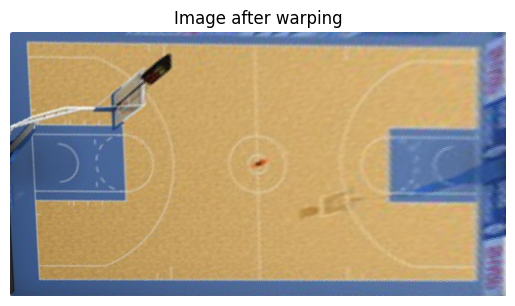

In [10]:
plot(arr2, title="Image after warping", savefig=True)

# Extra Credit: Normalized DLT Algorithm

In [11]:
# normalization with scaling using mean and std
def normalize_with_mean(points):
    points = np.array(points)
    mean = np.mean(points,0)
    std = np.std(points)
    
    T = np.array([[std/np.sqrt(2), 0, mean[0]],
                [0, std/np.sqrt(2), mean[1]],
                [0, 0, 1]])
    T = np.linalg.inv(T)
    
    points = np.dot(T, np.concatenate((points.T, np.ones((1, points.shape[0])))))
    points = points[0:2].T
    
    return points, T

In [12]:
# normalization with image width and height
def normalize_with_dim(points, img):
    points = np.array(points)
    img = np.array(img)
    w = img.shape[0]
    h = img.shape[1]
    
    T = np.array([[w+h, 0, w/2],
                 [0, w+h, h/2],
                 [0, 0, 1]])
    T = np.linalg.inv(T)
    
    points = np.dot(T, np.concatenate((points.T, np.ones((1, points.shape[0])))))
    points = points[0:2].T
    
    return points, T

In [13]:
p1, T = normalize_with_mean(img1_points)
p2, T_ = normalize_with_mean(img2_points)

A = get_A(p1, p2) # get A
U, S, V = np.linalg.svd(A, full_matrices=True, compute_uv=True) # SVD

H = V[-1,:] / V[-1,-1]
H = H.reshape(3,3)
H = np.dot(np.dot(np.linalg.pinv(T_), H), T)

print("Homography with normalization using mean:")
print()
print(H)

Homography with normalization using mean:

[[ 8.96325859e-01 -2.18004679e+00  4.36009359e+02]
 [ 1.66442581e+00  2.64160483e+00 -5.28320966e+02]
 [ 1.33554303e-04  3.59636825e-03  3.99987893e-01]]


In [14]:
p1, T = normalize_with_dim(img1_points, img1)
p2, T_ = normalize_with_dim(img2_points, img2)

A = get_A(p1, p2) # get A
U, S, V = np.linalg.svd(A, full_matrices=True, compute_uv=True) # SVD

H = V[-1,:] / V[-1,-1]
H = H.reshape(3,3)
H = np.dot(np.dot(np.linalg.pinv(T_), H), T)

print("Homography with normalization using dimensions:")
print()
print(H)

Homography with normalization using dimensions:

[[ 6.88452891e-01 -1.67445745e+00  3.34891491e+02]
 [ 1.27841761e+00  2.02897246e+00 -4.05794492e+02]
 [ 1.02580824e-04  2.76231026e-03  3.07224006e-01]]


# 1.3 DLT Algorithm using line feature locations

In [15]:
p1 = [0, 200, 1]
p2 = [246, 45, 1]
p3 = [419, 69, 1]
p4 = [287, 318, 1]

l1 = np.cross(p1,p2)
l2 = np.cross(p1,p4)
l3 = np.cross(p2,p3)
l4 = np.cross(p3,p4)

print(l1)
print(l2)
print(l3)
print(l4)

[   155    246 -49200]
[  -118    287 -57400]
[  -24   173 -1881]
[  -249   -132 113439]


In [16]:
img2_points = [[0,0], [939,0], [939,499], [0,499]]

p1_ = [0, 0, 1]
p2_ = [939, 0, 1]
p3_ = [939, 499, 1]
p4_ = [0, 499, 1]

l1_ = np.cross(p1_,p2_)
l2_ = np.cross(p1_,p4_)
l3_ = np.cross(p2_,p3_)
l4_ = np.cross(p3_,p4_)

print(l1_)
print(l2_)
print(l3_)
print(l4_)

[  0 939   0]
[-499    0    0]
[  -499      0 468561]
[     0   -939 468561]


In [19]:
# all lines have the form of (x,y,w)
# so l[0] = x, l[1] = y, l[2] = w

# Using inhomogenous solution
# we get 8 values for homography
A = [[0, 0, 0, -l1[0]*l1_[2], -l1[1]*l1_[2], -l1[2]*l1_[2], l1[0]*l1_[1], l1[1]*l1_[1]],
    [l1[0]*l1_[2], l1[1]*l1_[2], l1[2]*l1_[2], 0, 0, 0, -l1[0]*l1_[0], -l1[1]*l1_[0]],
    [0, 0, 0, -l2[0]*l2_[2], -l2[1]*l2_[2], -l2[2]*l2_[2], l2[0]*l2_[1], l2[1]*l2_[1]],
    [l2[0]*l2_[2], l2[1]*l2_[2], l2[2]*l2_[2], 0, 0, 0, -l2[0]*l2_[0], -l2[1]*l2_[0]],
    [0, 0, 0, -l3[0]*l3_[2], -l3[1]*l3_[2], -l3[2]*l3_[2], l3[0]*l3_[1], l3[1]*l3_[1]],
    [l3[0]*l3_[2], l3[1]*l3_[2], l3[2]*l3_[2], 0, 0, 0, -l3[0]*l3_[0], -l3[1]*l3_[0]],
    [0, 0, 0, -l4[0]*l4_[2], -l4[1]*l4_[2], -l4[2]*l4_[2], l4[0]*l4_[1], l4[1]*l4_[1]],
    [l4[0]*l4_[2], l4[1]*l4_[2], l4[2]*l4_[2], 0, 0, 0, -l4[0]*l4_[0], -l4[1]*l4_[0]]]

U, S, V = np.linalg.svd(A, full_matrices=True, compute_uv=True) # SVD
H = V[-1,:] / V[-1,-1]
print("Homography with line feature locations using inhomogenous homography:")
print()
print(H)

Homography with line feature locations using inhomogenous homography:

[ 2.21223101e+13  3.50851380e+13  2.94460044e+12 -5.91570109e+10
 -9.38207574e+10 -7.87412162e+09  2.50694747e+00  1.00000000e+00]


C:\Users\alexr\AppData\Local\Temp\ipykernel_12672\1204274089.py:12: RuntimeWarning: overflow encountered in scalar multiply
  [0, 0, 0, -l4[0]*l4_[2], -l4[1]*l4_[2], -l4[2]*l4_[2], l4[0]*l4_[1], l4[1]*l4_[1]],
C:\Users\alexr\AppData\Local\Temp\ipykernel_12672\1204274089.py:13: RuntimeWarning: overflow encountered in scalar multiply
  [l4[0]*l4_[2], l4[1]*l4_[2], l4[2]*l4_[2], 0, 0, 0, -l4[0]*l4_[0], -l4[1]*l4_[0]]]
